In [33]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
df = pd.read_csv(r'C:/Users/hhamadeh/Documents/Datasets/Spotify/top50.csv', encoding='latin')
df.head()

,Unnamed: 0,Track.Name,Artist.Name,Genre,Beats.Per.Minute,Energy,Danceability,Loudness..dB..,Liveness,Valence.,Length.,Acousticness..,Speechiness.,Popularity
0,1,Señorita,Shawn Mendes,canadian pop,117,55,76,-6,8,75,191,4,3,79
1,2,China,Anuel AA,reggaeton flow,105,81,79,-4,8,61,302,8,9,92
2,3,boyfriend (with Social House),Ariana Grande,dance pop,190,80,40,-4,16,70,186,12,46,85
3,4,Beautiful People (feat. Khalid),Ed Sheeran,pop,93,65,64,-8,8,55,198,12,19,86
4,5,Goodbyes (Feat. Young Thug),Post Malone,dfw rap,150,65,58,-4,11,18,175,45,7,94


In [3]:
df.drop('Unnamed: 0', axis=1, inplace=True)


Can we predict the popularity of a song based on some of these metrics?

    Energy: The energy of a song - the higher the value, the more energtic. song
    Danceability: The higher the value, the easier it is to dance to this song.
    Loudness (dB): The higher the value, the louder the song.
    Liveness: The higher the value, the more likely the song is a live recording.
    Valence: The higher the value, the more positive mood for the song.
    Length: The duration of the song.
    Acousticness: The higher the value the more acoustic the song is.
    Speechiness: The higher the value the more spoken word the song contains.
    Popularity: The higher the value the more popular the song is.

In [4]:
df.columns = ['Track', 'Artist', 'Genre', 'BPM', 'Energy', 'Danceability', 'Loudness (dB)', 'Liveness', 'Valence',
        'Length', 'Acousticness', 'Speechiness', 'Popularity']

In [5]:
# Check if there are any nulls
df.isnull().any()

Track            False
Artist           False
Genre            False
BPM              False
Energy           False
Danceability     False
Loudness (dB)    False
Liveness         False
Valence          False
Length           False
Acousticness     False
Speechiness      False
Popularity       False
dtype: bool

In [7]:
# Number of unique artists in top 50
df['Artist'].nunique()

38

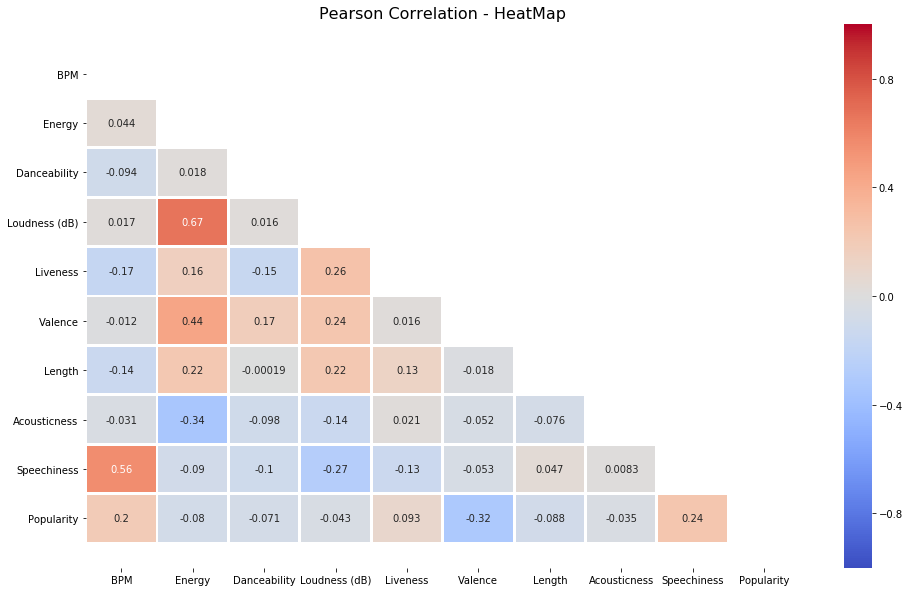

In [8]:
#### Pearson Correlation of Features
dfCorr = df[['BPM', 'Energy', 'Danceability', 'Loudness (dB)', 'Liveness', 'Valence',
        'Length', 'Acousticness', 'Speechiness', 'Popularity']].corr(method='pearson')


# Since a heatmap is mirrored along the diagnol, we can filter out the top half to make it nicer on the eyes
mask = np.zeros_like(dfCorr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True


plt.figure(figsize=(16, 10))
ax = sns.heatmap(dfCorr,
           cmap='coolwarm',         # Hotter = Positive, Colder = Negative
           annot=True,
                 vmin=-1,           # set the minimum value of the color scale to -1
                linewidths=2,
                linecolor='white',
                mask=mask)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title("Pearson Correlation - HeatMap", size=16)
ax.tick_params(axis='both', which='major', rotation=0, labelsize=10)

Strong correlation between Energy and Loudness (dB).

Popularity and Speechiness/BPM have an interesting result in this heatmap as well.

Things to consider:

1. Energy vs Loudness
2. Beats Per Minute vs Speechiness
3. Genre vs Popularity


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


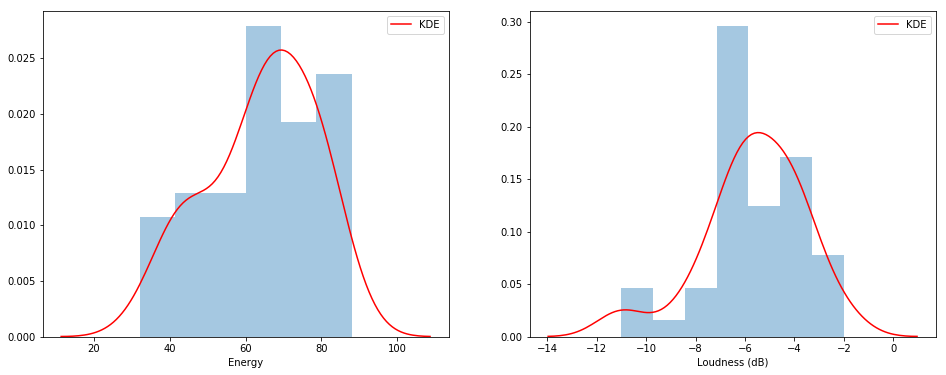

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

sns.distplot(df['Energy'], kde=True, rug=False, kde_kws={'color' : 'r', 'label' : 'KDE'},
             ax=ax[0])
sns.distplot(df['Loudness (dB)'], kde=True, rug=False, kde_kws={'color' : 'r', 'label' : 'KDE'},
             ax=ax[1])

In [57]:
# Let's see if we can make a nicer gaussian
skew = df[['Energy', 'Loudness (dB)']].skew()
print(skew)

# Box Cox Transformations (to reduce skew)
energyXF = np.asarray(df['Energy'])
loudnessXF = np.asarray(abs(df['Loudness (dB)']))

e1 = stats.boxcox(energyXF)[0]
l1 = stats.boxcox(loudnessXF)[0]

transformed = pd.DataFrame({'Energy' : e1, 'Loudness (dB)' : l1})
transformed['Loudness (dB)'] = transformed['Loudness (dB)'].apply(lambda x: -abs(x))

print(transformed.skew())

Energy          -0.453199
Loudness (dB)   -0.831915
dtype: float64
Energy          -0.157699
Loudness (dB)   -0.009283
dtype: float64


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


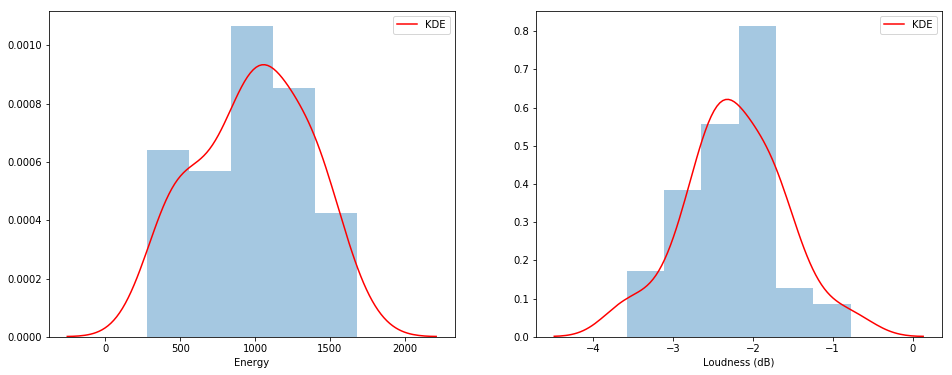

In [58]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

sns.distplot(transformed['Energy'], kde=True, rug=False, kde_kws={'color' : 'r', 'label' : 'KDE'},
             ax=ax[0])
sns.distplot(transformed['Loudness (dB)'], kde=True, rug=False, kde_kws={'color' : 'r', 'label' : 'KDE'},
             ax=ax[1])